In [1]:
!pip install -q git+https://github.com/huggingface/transformers
!pip install -q qwen-vl-utils
!pip install -q torch torchvision pillow accelerate

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 514.9/514.9 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 2.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 5.1.2 requires transformers<5.0.0,>=4.41.0, but you have transformers 5.0.0.dev0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 MB 23.0 MB/s eta 0:00:00


In [2]:
import torch
from transformers import Qwen2VLForConditionalGeneration, AutoProcessor
from qwen_vl_utils import process_vision_info
from PIL import Image
from google.colab import files
from IPython.display import display

🚨 `image_seq_length` is part of ImagesKwargs, but not documented. Make sure to add it to the docstring of the function in /usr/local/lib/python3.12/dist-packages/transformers/image_processing_utils_fast.py.


In [3]:
from huggingface_hub import login
token = "token"
login(token)

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU Name: Tesla T4


In [5]:
model_name = "Qwen/Qwen2-VL-2B-Instruct"

model = Qwen2VLForConditionalGeneration.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    device_map="auto"
)

processor = AutoProcessor.from_pretrained(model_name)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/272 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/347 [00:00<?, ?B/s]

The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.


🚨 `image_seq_length` is part of Qwen2VLImageProcessorKwargs, but not documented. Make sure to add it to the docstring of the function in /usr/local/lib/python3.12/dist-packages/transformers/models/qwen2_vl/image_processing_qwen2_vl_fast.py.


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

chat_template.json: 0.00B [00:00, ?B/s]

In [6]:
def analyze_floor_plan(image_path, query=None):
    if query is None:
        query = """
        Analyze this architectural floor plan carefully:

        1. DIMENSIONS:
           - Plot width (meters)
           - Plot depth (meters)
           - Total area (square meters)

        2. ROOMS:
           - Count bedrooms
           - Count bathrooms/WC
           - Kitchen (yes/no)
           - Living room (yes/no)
           - Dining room (yes/no)
           - Storage rooms

        3. PARKING:
           - Number of car parking spaces

        4. OUTDOOR:
           - Lawn areas count
           - Flower beds count

        Provide specific numbers.
        """

    messages = [
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                    "image": image_path,
                },
                {"type": "text", "text": query},
            ],
        }
    ]

    text = processor.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )

    image_inputs, video_inputs = process_vision_info(messages)

    inputs = processor(
        text=[text],
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt",
    )

    inputs = inputs.to(device)

    generated_ids = model.generate(**inputs, max_new_tokens=512)
    generated_ids_trimmed = [
        out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]

    output_text = processor.batch_decode(
        generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )

    return output_text[0]

Saving Screenshot 2025-11-06 000232.png to Screenshot 2025-11-06 000232.png

✓ Image uploaded: Screenshot 2025-11-06 000232.png

Displaying image:


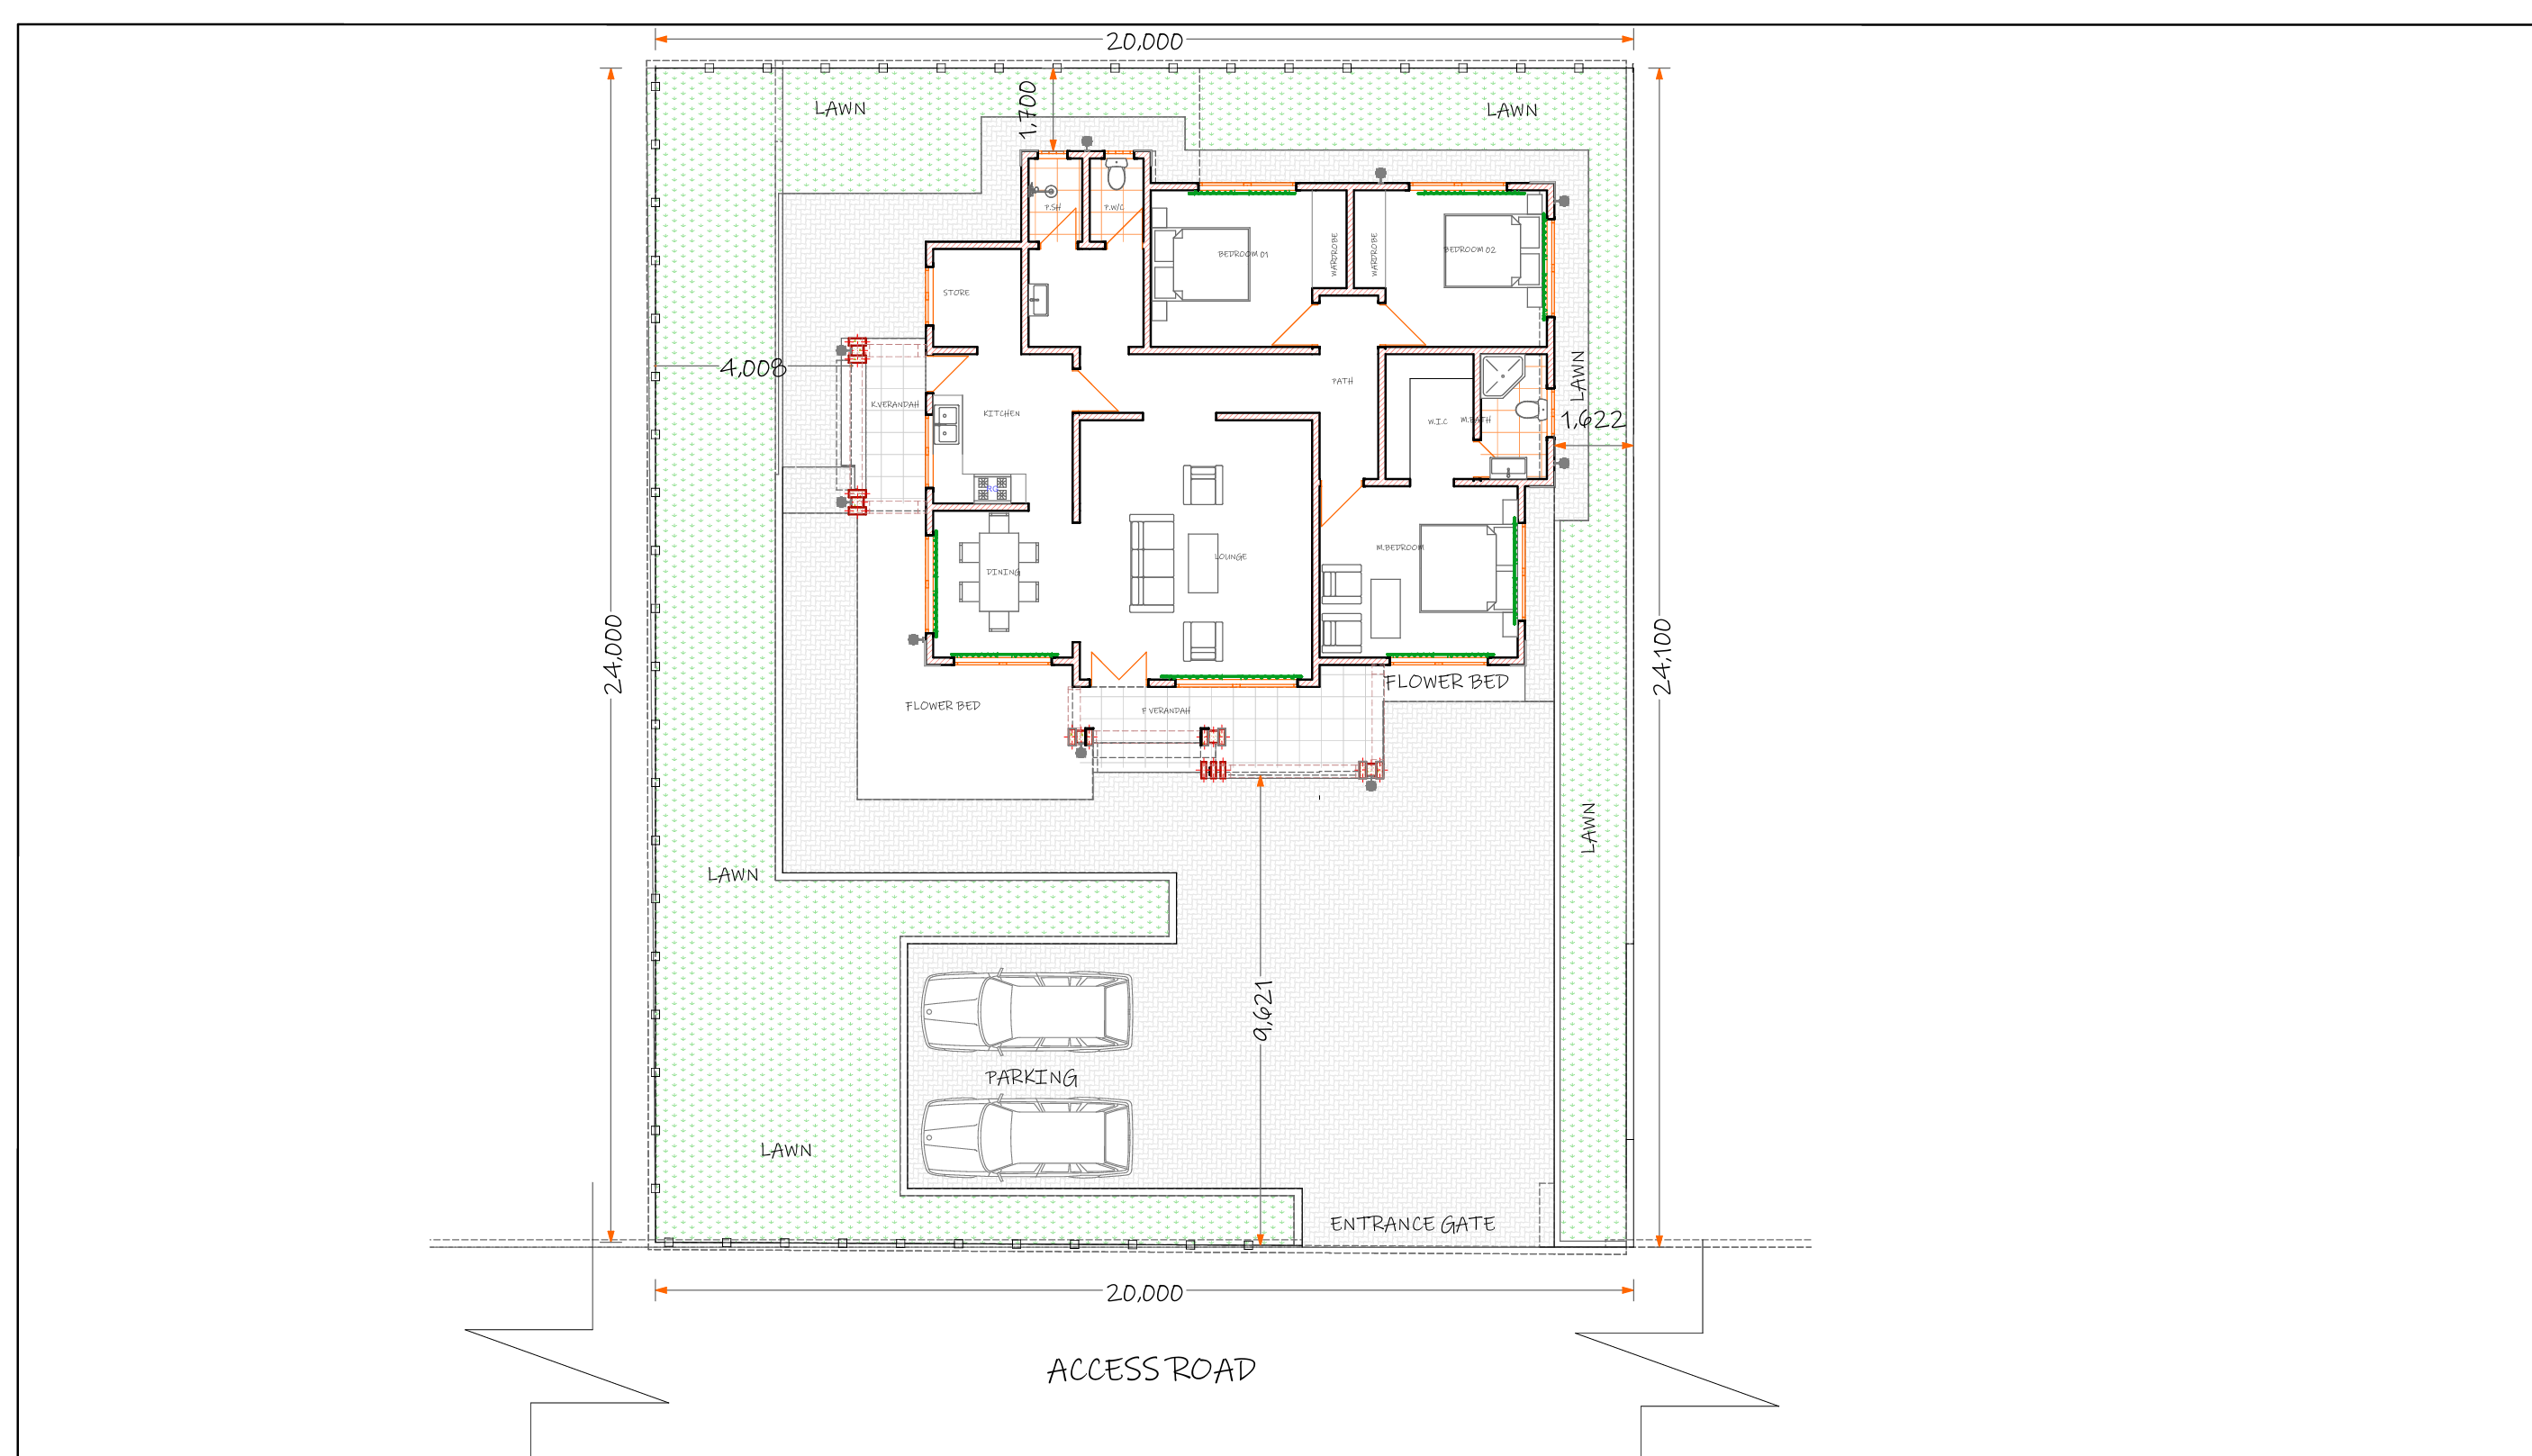

In [7]:
uploaded = files.upload()
image_path = list(uploaded.keys())[0]
img = Image.open(image_path)
display(img)

In [8]:
def ask_question(image_path, question):
    return analyze_floor_plan(image_path, question)

In [9]:
questions = [
    "How many bedrooms are in this floor plan?",
    "How many bathrooms or WC are shown?",
    "How many parking spaces for cars?",
    "What is the plot width in meters?",
    "What is the plot depth in meters?",
    "What is the total area in square meters?",
    "How many lawn areas are there?",
    "List all the rooms you can identify with their names."
]

In [10]:
answers = {}
for i, question in enumerate(questions, 1):
    print(f"{i}. {question}")
    answer = ask_question(image_path, question)
    answers[question] = answer
    print(f"   → {answer}\n")

1. How many bedrooms are in this floor plan?
   → The floor plan shows three bedrooms.

2. How many bathrooms or WC are shown?
   → The floor plan shows two bathrooms or WC.

3. How many parking spaces for cars?
   → There are two parking spaces for cars in the plan.

4. What is the plot width in meters?
   → The plot width in meters is 24,000 meters.

5. What is the plot depth in meters?
   → The plot depth in the image is 20,000 meters.

6. What is the total area in square meters?
   → To calculate the total area of the house in square meters, we need to multiply the length by the width of each room and then sum up the areas of all the rooms.

1. **Length of the house:**
   - 24,000 meters
   - Width of the house: 20,000 meters

2. **Total area of the house:**
   \[
   \text{Total area} = \text{Length} \times \text{Width}
   \]
   \[
   \text{Total area} = 24,000 \, \text{m} \times 20,000 \, \text{m} = 4,800,000,000 \, \text{m}^2
   \]

Therefore, the total area of the house is 4,800

In [13]:
result = analyze_floor_plan(image_path)

In [15]:
summary = f"""
FLOOR PLAN ANALYSIS REPORT
{'='*30}

IMAGE: {image_path}
FULL ANALYSIS:
{'-'*30}
{result}

DETAILED Q&A:
{'-'*30}
"""

In [16]:
for i, (q, a) in enumerate(answers.items(), 1):
    summary += f"\n{i}. {q}\n   → {a}\n"

print(summary)


FLOOR PLAN ANALYSIS REPORT

IMAGE: Screenshot 2025-11-06 000232.png
FULL ANALYSIS:
------------------------------
Based on the architectural floor plan provided, here are the specific numbers for each element:

1. **Dimensions:**
   - Plot width: 24,000 meters
   - Plot depth: 20,000 meters
   - Total area: 480,000 square meters

2. **Rooms:**
   - Number of bedrooms: 4
   - Number of bathrooms/WC: 2
   - Kitchen: Yes
   - Living room: Yes
   - Dining room: Yes
   - Storage rooms: 2

3. **Parking:**
   - Number of car parking spaces: 2

4. **Outdoor:**
   - Lawn areas: 2
   - Flower beds: 2

This floor plan appears to be a 4-bedroom, 2-bathroom house with a kitchen, living room, dining room, and storage rooms. It also includes 2 car parking spaces and 2 lawn areas with flower beds.

DETAILED Q&A:
------------------------------

1. How many bedrooms are in this floor plan?
   → The floor plan shows three bedrooms.

2. How many bathrooms or WC are shown?
   → The floor plan shows two ba

In [17]:
output_file = "floor_plan_analysis.txt"

with open(output_file, 'w', encoding='utf-8') as f:
    f.write(summary)

In [18]:
def interactive_mode(image_path):
    print("Interactive mode activated. Type 'exit' to quit.")
    while True:
        question = input("\nYour question: ")
        if question.lower() == 'exit':
            break

        print("Processing...")
        answer = ask_question(image_path, question)
        print(f"\nAnswer: {answer}")
        print("-"*70)

In [19]:
interactive_mode(image_path)

Interactive mode activated. Type 'exit' to quit.

Your question: Can See Any Table ?
Processing...

Answer: The floor plan you provided is a detailed architectural drawing of a house. It shows the layout of the house, including the various rooms, bathrooms, and other features. The dimensions are marked in meters, and the layout is clearly defined with different sections and rooms labeled. The drawing includes a detailed view of the house's exterior, including the entrance, parking area, and garden areas.
----------------------------------------------------------------------

Your question: How Many cars in the floor plan
Processing...

Answer: The floor plan shows two cars parked in the driveway.
----------------------------------------------------------------------

Your question: How Many Toilet bowl in the floor plan 
Processing...

Answer: The floor plan shows two toilet bowls.
----------------------------------------------------------------------

Your question: What is a Total ar